## Stock trading modelling with RNN LSTM architecture.### Date: 10th December 2018

In [2]:
import numpy as np
import pandas as pd
import math
import h5py
import fix_yahoo_finance as yf
pd.core.common.is_list_like = pd.api.types.is_list_like
import pandas_datareader.data as pdr
from time import sleep
from datetime import datetime as dt
import talib as tb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import MinMaxScaler


# Libraries required by FeatureSelector()
import lightgbm as lgb
import gc
from itertools import chain
from sklearn.cluster import KMeans
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from mpl_finance import candlestick_ohlc
import copy
from matplotlib.dates import (DateFormatter, WeekdayLocator, DayLocator, MONDAY)

import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.recurrent import LSTM
from keras.layers.recurrent import GRU
from keras.callbacks import ModelCheckpoint, EarlyStopping, Callback, TensorBoard
from keras.models import load_model
from keras.layers import Dense, Dropout, Activation, Flatten, Reshape
from keras.layers import Conv1D, MaxPooling1D, LeakyReLU, PReLU, GlobalAveragePooling1D
from keras import regularizers
from keras import backend as K

Using TensorFlow backend.


Note: After loading the above libraries, before proceeding further, please proceed to the last cell in this notebook to run FeatureSelector() class, courtesy of William Koehrsen. See reference #4 

#### Check Tensorflow version. 
As shown below, the Tensorflow version the deep learning algorithms trained in this notebook and its associated Python program MP2.py is version 1.10.0, with CUDA v9.0 and cuDNN v7

Tensorflow GPU version needs to have matching versions of Tensorflow + cuDNN + CUDA to be activated and made available for faster deep learning training. 
The following link provides an instruction to ensure compatibility: 
https://stackoverflow.com/questions/50622525/which-tensorflow-and-cuda-version-combinations-are-compatible

If Tensoflow or Keras library is not loaded properly from the above cell, the enclosed readme.txt provides installation instructions.
Once GPU is available for Tensorflow, automatically, Keras will choose the machine's GPU for training. 

In [3]:
print(tf.__version__)

1.10.0


#### Check what device is available for deep learning training. 

In [3]:
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

['/job:localhost/replica:0/task:0/device:GPU:0',
 '/job:localhost/replica:0/task:0/device:GPU:1']

In [5]:
import tensorflow as tf
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 12219235224218119333
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 10911298356
locality {
  bus_id: 1
  links {
    link {
      device_id: 1
      type: "StreamExecutor"
      strength: 1
    }
  }
}
incarnation: 4615395646033943734
physical_device_desc: "device: 0, name: GeForce GTX 1080 Ti, pci bus id: 0000:03:00.0, compute capability: 6.1"
, name: "/device:GPU:1"
device_type: "GPU"
memory_limit: 10520061543
locality {
  bus_id: 1
  links {
    link {
      type: "StreamExecutor"
      strength: 1
    }
  }
}
incarnation: 2443503486424383782
physical_device_desc: "device: 1, name: GeForce GTX 1080 Ti, pci bus id: 0000:04:00.0, compute capability: 6.1"
]


## Introduction

In this mini project I'm testing two machine learning algorithms for price prediction application: A multi-layer recurrent neural network with Long-short term memory (LSTM) cells and a hybrid consists of 2 convolutional neural network layers & 1 LSTM neural network layers. 

With CAPM model in mind, future stock price (the next day) is predicted with today and past market (S&P 500) and stock data. Each set of stock and market data consists of indicator time series derived from their respective price and volume data.

Depends on user's computational resource, it may take sometime to train the neural network models. MP2.py progrma takes about 15 minutes to train on both RNN LSTM and CNN + RNN LSTM models on a machine equipped with Nvidia Geforce 1080Ti.    For user convenience, I have included their pre-trained models: best_cnn_model_AAPL.h5 & best_lstm_model_AAPL.h5 for which MP2.py will skip training and predict from the loaded pre-trained models.

Whereas for this notebook, if pre-trained models are available the loading sequence will retrain existing pre-trained models with the hope of improved learning. User may rename the pre-trained models for this notebook to start training from fresh. Or proceed directly to the respecitve model loading cell to get instant prediction. 

All training and the pre-trained models in this notebook and MP2.py are done for stock AAPL. 
In MP2.py, user is also given the option to choose other stocks, the program will check if enough historical data is available for training, otherwise user will be prompted to enter a different stock quote. 

#### Note: The supplied pre-trained CNN and RNN models: best_cnn_model_AAPL.h5 & best_lstm_model_AAPL.h5 work only when feature selection algorithm selected 25 features. I notice that certain machine behaves differently and may selects different number of features. In that case, a new training will be needed to use the locally processed features data for prediction.  

### Global Parameters

In [4]:
# Range of date
START = dt(2000, 1, 1)
END = dt(2018, 12, 7)
PREDICTION_AHEAD = 1
TRAIN_PORTION = 0.9

## 1 Data Preprocessing

In [5]:
class Data: 
    def __init__(self, symbol):
        self.q = symbol
        self._get_daily_data()
        self.technical_indicators_df()

    def _get_daily_data(self):
        """
        This class prepares data by downloading historical data from Yahoo Finance,

        """
        flag = False
        # Set counter for download trial
        counter = 0

        # Safety loop to handle unstable Yahoo finance download
        while not flag and counter < 6:
            try:
                # Define data range
                yf.pdr_override()
                self.daily_data = pdr.get_data_yahoo(self.q, START, END)
                flag = True

            except:
                flag = False
                counter += 1

                if counter < 6:
                    continue
                else:
                    raise Exception("Yahoo finance is down, please try again later. ")

    def technical_indicators_df(self):
        o = self.daily_data['Open'].values
        c = self.daily_data['Close'].values
        h = self.daily_data['High'].values
        l = self.daily_data['Low'].values
        v = self.daily_data['Volume'].astype(float).values
        # define the technical analysis matrix

        # Most data series are normalized by their series' mean
        ta = pd.DataFrame()
        ta['MA5'] = tb.MA(c, timeperiod=5)
        ta['MA10'] = tb.MA(c, timeperiod=10)
        ta['MA20'] = tb.MA(c, timeperiod=20)
        ta['MA60'] = tb.MA(c, timeperiod=60)
        ta['MA120'] = tb.MA(c, timeperiod=120)
        ta['MA5'] = tb.MA(v, timeperiod=5)
        ta['MA10'] = tb.MA(v, timeperiod=10)
        ta['MA20'] = tb.MA(v, timeperiod=20)
        ta['ADX'] = tb.ADX(h, l, c, timeperiod=14)
        ta['ADXR'] = tb.ADXR(h, l, c, timeperiod=14)
        ta['MACD'] = tb.MACD(c, fastperiod=12, slowperiod=26, signalperiod=9)[0]
        ta['RSI'] = tb.RSI(c, timeperiod=14)
        ta['BBANDS_U'] = tb.BBANDS(c, timeperiod=5, nbdevup=2, nbdevdn=2, matype=0)[0]
        ta['BBANDS_M'] = tb.BBANDS(c, timeperiod=5, nbdevup=2, nbdevdn=2, matype=0)[1]
        ta['BBANDS_L'] = tb.BBANDS(c, timeperiod=5, nbdevup=2, nbdevdn=2, matype=0)[2]
        ta['AD'] = tb.AD(h, l, c, v)
        ta['ATR'] = tb.ATR(h, l, c, timeperiod=14)
        ta['HT_DC'] = tb.HT_DCPERIOD(c)
        ta["High/Open"] = h/o
        ta["Low/Open"] = l/o
        ta["Close/Open"] = c/o

        self.ta = ta

    def label(self, df, seq_length):            
        return (df['Returns'] > 0).astype(int)

    def scale_data(self):
        """
        This function scale raw data for effective ML training. Stadardization, normalization and MInMax methods are performed.
        """
        # Get the feature and target labels
        self.X_fs = self.X_fs.dropna()

        # Normalization scaling
        self.normalized_scaler = Normalizer()
        normalized = self.normalized_scaler.fit_transform(self.X_fs)
        self._normalized = pd.DataFrame(normalized, index=self.X_fs.index, columns=self.X_fs.columns)

        # Standardization scaling
        self.standardized_scaler = StandardScaler()
        standardized = self.standardized_scaler.fit_transform(self.X_fs)
        self._standardized = pd.DataFrame(standardized, index=self.X_fs.index, columns=self.X_fs.columns)

        # MinMax scaling
        self.minmaxed_scaler = MinMaxScaler(feature_range=(0,1))
        minmaxed = self.minmaxed_scaler.fit_transform(self.X_fs)
        self._minmaxed = pd.DataFrame(minmaxed, index=self.X_fs.index, columns=self.X_fs.columns)

        self.X_fs = self._minmaxed
        #self.X_fs = self._normalized
        #self.X_fs = self._standardized
        self.y = self.y.loc[self.X_fs.index]

    def preprocessing(self):

        self.daily_data['Returns'] = pd.Series((self.daily_data['Close'] / self.daily_data['Close'].shift(1) - 1)*100, index=self.daily_data.index)
        seq_length = 3
        self.daily_data['Volume'] = self.daily_data['Volume'].astype(float)
        self.X = self.daily_data[['Open', 'Close', 'High', 'Low', 'Volume']]
        self.y = self.label(self.daily_data, seq_length)
        X_shift = [self.X]
        for i in range(1,seq_length):
            shifted_df = self.daily_data[['Open', 'Close', 'High', 'Low', 'Volume']].shift(i)
            X_shift.append(shifted_df/shifted_df.mean())
        ohlc = pd.concat(X_shift, axis=1)
        ohlc.columns = sum([[c + 'T-{}'.format(i) for c in ['Open', 'Close', 'High', 'Low', 'Volume']] \
                    for i in range(seq_length)], [])
        self.ta.index = ohlc.index
        self.X = pd.concat([ohlc,self.ta], axis=1)
        self.Xy = pd.concat([self.X,self.y], axis=1)

        fs = FeatureSelector(data=self.X, labels=self.y)
        fs.identify_all(selection_params={'missing_threshold': 0.6,
                                          'correlation_threshold': 0.9,
                                          'task': 'regression',
                                          'eval_metric': 'auc',
                                          'cumulative_importance': 0.99})
        self.X_fs = fs.remove(methods='all', keep_one_hot=True)
        # Add the y label, close price of days ahead(PREDICTION_AHEAD) 
        shifted_close_price = self.daily_data['Close'].shift(-PREDICTION_AHEAD)
        self.X_fs['Predict-Y'] = shifted_close_price.loc[self.X_fs.index].dropna()
        self.original = self.X_fs
        self.scale_data()
        self.Xy_fs = pd.concat([self.X_fs,self.y], axis=1)

### Stock Data

In [6]:
symbol = "AAPL"

In [7]:
stock_data = Data(symbol)
stock_data.preprocessing()
stock_raw, stock_fs = stock_data.X, stock_data.X_fs

[*********************100%***********************]  1 of 1 downloaded
0 features with greater than 0.60 missing values.

0 features with a single unique value.

20 features with a correlation magnitude greater than 0.90.

Training Gradient Boosting Model


0 features with zero importance after one-hot encoding.

29 features required for cumulative importance of 0.99 after one hot encoding.
4 features do not contribute to cumulative importance of 0.99.

20 total features out of 33 identified for removal after one-hot encoding.

['missing', 'single_unique', 'collinear', 'zero_importance', 'low_importance'] methods have been run

Removed 20 features.


### Market (context) Data

In [8]:
market_data = Data("^GSPC")
market_data.preprocessing()
market_raw, market_fs = market_data.X, market_data.X_fs

[*********************100%***********************]  1 of 1 downloaded
0 features with greater than 0.60 missing values.

0 features with a single unique value.

21 features with a correlation magnitude greater than 0.90.

Training Gradient Boosting Model


0 features with zero importance after one-hot encoding.

30 features required for cumulative importance of 0.99 after one hot encoding.
3 features do not contribute to cumulative importance of 0.99.

21 total features out of 33 identified for removal after one-hot encoding.

['missing', 'single_unique', 'collinear', 'zero_importance', 'low_importance'] methods have been run

Removed 21 features.


### Stock & market dataframe assembly

In [9]:
stock_fs = stock_fs.dropna()
market_fs.columns = [c + '_M' for c in market_fs.columns]
market_fs = market_fs.drop(['Predict-Y_M'], axis=1).dropna()
stock_context_fs = pd.concat([market_fs, stock_fs], axis=1)
stock_context_fs = stock_context_fs.dropna()
stock_context_fs

,OpenT-0_M,VolumeT-0_M,ADX_M,ADXR_M,MACD_M,RSI_M,AD_M,ATR_M,HT_DC_M,High/Open_M,...,MA5,ADX,MACD,RSI,AD,HT_DC,High/Open,Low/Open,Close/Open,Predict-Y
Date,,,,,,,,,,,,,,,,,,,,,
2000-02-29,0.296246,0.076416,0.523986,0.520735,0.450654,0.406768,0.006280,0.356583,0.400108,0.148376,...,0.105981,0.017518,0.614738,0.498052,0.169296,0.245955,0.194599,0.959047,0.514882,0.016081
2000-03-01,0.304384,0.082704,0.507238,0.504430,0.470651,0.455214,0.006705,0.342502,0.436750,0.115585,...,0.149055,0.038627,0.617042,0.658600,0.177632,0.277408,0.682388,0.997549,0.871980,0.014797
2000-03-02,0.310040,0.075903,0.487858,0.496944,0.489642,0.464927,0.007031,0.328355,0.470470,0.049530,...,0.144407,0.058228,0.617456,0.543652,0.175561,0.298689,0.044240,0.768843,0.321006,0.015724
2000-03-03,0.311179,0.071551,0.442886,0.475296,0.523498,0.560351,0.007710,0.331905,0.482299,0.195334,...,0.149701,0.074041,0.618634,0.595812,0.178742,0.298715,0.161220,0.818445,0.577228,0.015366
2000-03-06,0.323321,0.060623,0.401126,0.447017,0.539675,0.496471,0.007381,0.329863,0.472330,0.003749,...,0.141301,0.090642,0.619091,0.565643,0.177278,0.283394,0.148636,0.963091,0.467786,0.014932
2000-03-07,0.315396,0.086308,0.391999,0.436914,0.530462,0.390518,0.006704,0.359288,0.449459,0.052829,...,0.134457,0.092277,0.618899,0.529313,0.176009,0.258804,0.047399,0.804597,0.365546,0.014797
2000-03-08,0.299600,0.076299,0.385957,0.431141,0.531324,0.429577,0.007089,0.358108,0.429716,0.124233,...,0.076984,0.085465,0.618505,0.517873,0.176798,0.236196,0.051821,0.836779,0.449321,0.014835
2000-03-09,0.304508,0.069092,0.351731,0.422227,0.555344,0.537716,0.007834,0.378690,0.423595,0.238177,...,0.074521,0.082051,0.618135,0.520626,0.177333,0.240709,0.204519,0.899004,0.522916,0.015376
2000-03-10,0.320007,0.070515,0.318625,0.416959,0.570651,0.517113,0.007287,0.368653,0.417339,0.077829,...,0.069188,0.086675,0.618298,0.559265,0.178291,0.265360,0.307807,0.973726,0.610489,0.014690


### Visualization of selected features

There are a total of 25 features selected and 1 label 

In [10]:
len(stock_context_fs.columns)

26

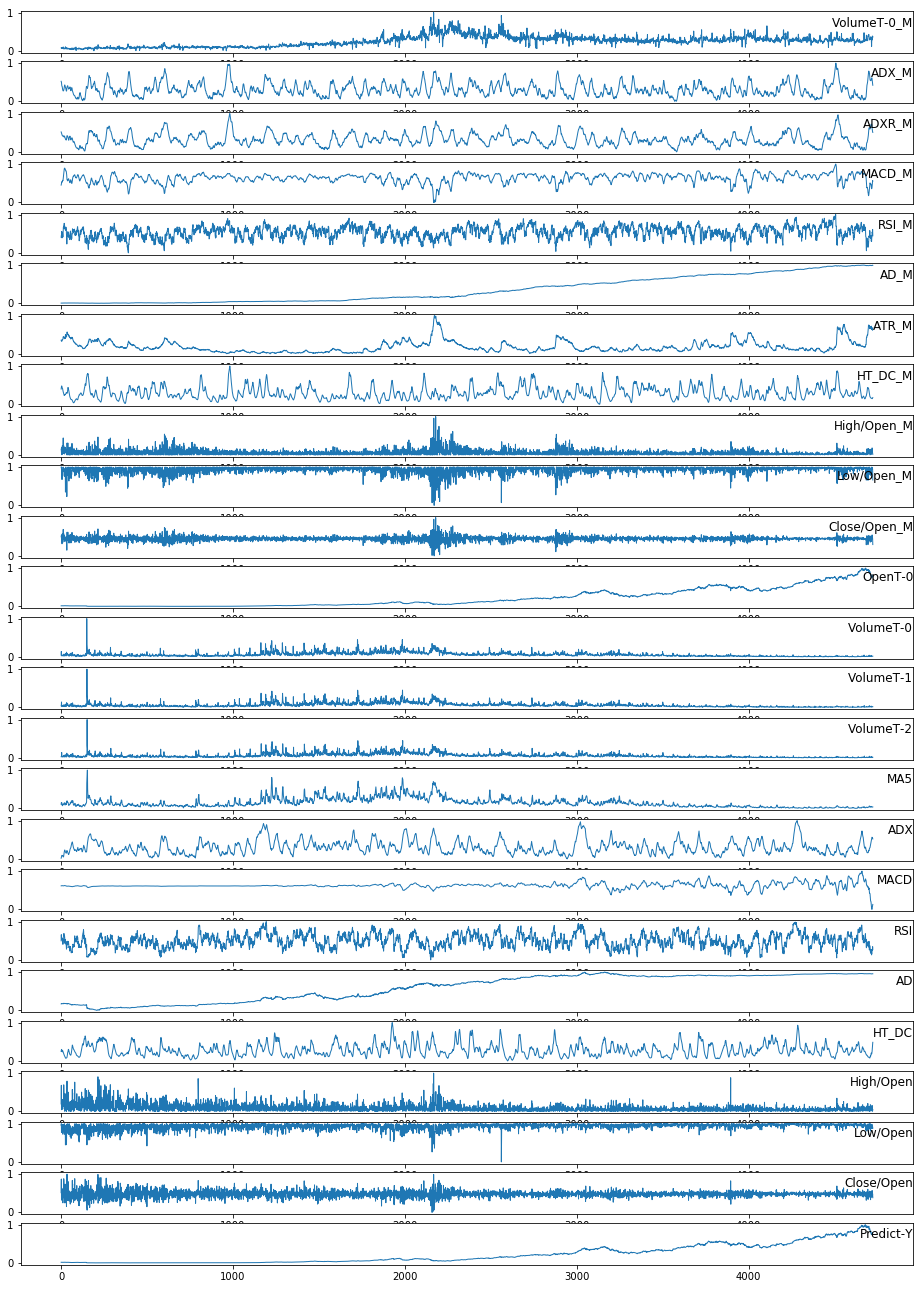

In [11]:
df_values = stock_context_fs.values
i = 1
# plot each column
plt.figure(figsize=[16, 24])
for i in range(1, len(stock_context_fs.columns)):
    plt.subplot(len(stock_context_fs.columns), 1, i)
    plt.plot(df_values[:, i], lw=1)
    plt.title(stock_context_fs.columns[i], y=0.5, loc='right')
    i += 1
plt.savefig('features_visualization_{}.png'.format(symbol))
plt.show()

## 2 Model Building, Training, Evaluation & Prediction

In [12]:
# Set early stopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=40)
#tbd = TensorBoard(log_dir='./tensorboard_logs', histogram_freq=1, embeddings_freq=1)

In [13]:
def train_model(model, train_X, train_y, model_type):
    if model_type == "LSTM":
        batch_size=4
        mc = ModelCheckpoint('best_lstm_model_ip_{}.h5'.format(symbol), monitor='val_loss', save_weights_only=False,
                             mode='min', verbose=1, save_best_only=True)
        try: 
            model = load_model('./best_lstm_model_ip_{}.h5'.format(symbol))
            print("Loading pre-saved model ...")
        except: 
            print("No pre-saved model, training new model.")
            pass
    elif model_type == "CNN":
        batch_size=8
        mc = ModelCheckpoint('best_cnn_model_ip_{}.h5'.format(symbol), monitor='val_loss', save_weights_only=False,
                             mode='min', verbose=1, save_best_only=True)
        try: 
            model = load_model('./best_cnn_model_ip_{}.h5'.format(symbol))
            print("Loading pre-saved model ...")
        except: 
            print("No pre-saved model, training new model.")
            pass
    # fit network
    history = model.fit(
        train_X, 
        train_y, 
        epochs=500, 
        batch_size=batch_size, 
        validation_split=0.2, 
        verbose=2, 
        shuffle=True,
        #callbacks=[es, mc, tb, LearningRateTracker()])
        callbacks=[es, mc])
    
    if model_type == "LSTM":
        model.save('./best_lstm_model_ip_{}.h5'.format(symbol))
    elif model_type == "CNN":
        model.save('./best_cnn_model_ip_{}.h5'.format(symbol))
    
    return history, model

In [14]:
def plot_training(history,nn):
    # plot history
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='test')
    plt.legend()
    plt.title('Training loss history for {} model for {}'.format(nn, symbol))
    plt.savefig('history_{}_{}.png'.format(nn, symbol))
    plt.show()

In [15]:
def plot_prediction(original, trained, train_len, nn):

    """
    Function to plot all portfolio cumulative returns
    """
    # Set a palette so that all 14 lines can be better differentiated
    color_palette = ['#e6194b', '#3cb44b', '#4363d8']
    fig, ax = plt.subplots(figsize=(14, 6))
    ax.plot(original.index, original, '-', label="Original price", linewidth=2, color=color_palette[0])
    ax.plot(trained.iloc[:train_len].index, trained.iloc[:train_len], '-', label="Trained price", linewidth=2,
            color=color_palette[1], alpha=0.8)
    ax.plot(trained.iloc[train_len:].index, trained.iloc[train_len:], '-', label="Predicted price", linewidth=2,
            color=color_palette[2])
    plt.legend()
    plt.xlabel('Date')
    plt.ylabel('Stock price')
    plt.title('Original, trained & predicted stock price trained on {} model for {}'.format(nn, symbol))
    plt.subplots_adjust(hspace=0.5)

    # Display and save the graph
    plt.savefig('prediction_{}_{}.png'.format(nn, symbol))
    # Inform user graph is saved and the program is ending.
    print(
        "Plot saved as prediction_{}.png. When done viewing, please close this plot for next plot. Thank You!".format(
            nn))
    plt.show()

In [16]:
class LearningRateTracker(Callback):
    def on_epoch_end(self, epoch, logs={}):
        optimizer = self.model.optimizer
        lr = K.eval(optimizer.lr * (1. / (1. + optimizer.decay * optimizer.iterations)))
        print('\nLR: {:.6f}\n'.format(lr))

### Recurrent Neural network with LSTM training 

In [16]:
def split_data_rnn(df_values):
    # split into train and test sets
    n_train = TRAIN_PORTION * df_values.shape[0]
    train = df_values[:int(n_train), :]
    test = df_values[int(n_train):, :]
    # split into input and outputs
    train_X, train_y = train[:, :-1], train[:, -1]
    test_X, test_y = test[:, :-1], test[:, -1]
    # reshape input to be 3D [samples, timesteps, features]
    train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
    test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
    print(train_X.shape)
    print(train_y.shape)
    print(test_X.shape)
    print(test_y.shape)
    return train_X, train_y, test_X, test_y

train_X, train_y, test_X, test_y = split_data_rnn(df_values)

(4250, 1, 25)
(4250,)
(473, 1, 25)
(473,)


In [19]:
def build_rnn_model(train_X):
    # design network
    print("\n")
    print("RNN LSTM model architecture >")
    model = Sequential()
    model.add(LSTM(256, kernel_initializer='random_uniform',
                   bias_initializer='zeros', return_sequences=True,
                   input_shape=(train_X.shape[1], train_X.shape[2])))
    model.add(Dropout(0.25))
    model.add(LSTM(64, kernel_initializer='random_uniform',
                   # kernel_regularizer=regularizers.l2(0.001),
                   # activity_regularizer=regularizers.l1(0.001),
                   bias_initializer='zeros'))
    model.add(Dropout(0.25))
    model.add(Dense(1))
    optimizer = keras.optimizers.RMSprop(lr=0.01, rho=0.9, epsilon=1e-08, decay=0.0002)
    # optimizer = keras.optimizers.Adagrad(lr=0.03, epsilon=1e-08, decay=0.00002)
    # optimizer = keras.optimizers.Adam(lr=0.0001)
    # optimizer = keras.optimizers.Nadam(lr=0.0002, beta_1=0.9, beta_2=0.999, schedule_decay=0.004)
    # optimizer = keras.optimizers.Adamax(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0)
    # optimizer = keras.optimizers.Adadelta(lr=1.0, rho=0.95, epsilon=None, decay=0.0)

    model.compile(loss='mae', optimizer=optimizer, metrics=['mse', 'mae'])
    model.summary()
    return model
model_lstm = build_rnn_model(train_X)



RNN LSTM model architecture >
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 1, 256)            288768    
_________________________________________________________________
dropout_1 (Dropout)          (None, 1, 256)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                82176     
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 371,009
Trainable params: 371,009
Non-trainable params: 0
_________________________________________________________________


In [56]:
history_lstm, model_lstm = train_model(model_lstm, train_X, train_y, "LSTM")

No pre-saved model, training new model.
Train on 3400 samples, validate on 850 samples
Epoch 1/500
 - 8s - loss: 0.0463 - mean_squared_error: 0.0075 - mean_absolute_error: 0.0463 - val_loss: 0.1192 - val_mean_squared_error: 0.0185 - val_mean_absolute_error: 0.1192

Epoch 00001: val_loss improved from inf to 0.11924, saving model to best_lstm_model_sm.h5
Epoch 2/500
 - 5s - loss: 0.0288 - mean_squared_error: 0.0020 - mean_absolute_error: 0.0288 - val_loss: 0.0595 - val_mean_squared_error: 0.0054 - val_mean_absolute_error: 0.0595

Epoch 00002: val_loss improved from 0.11924 to 0.05952, saving model to best_lstm_model_sm.h5
Epoch 3/500
 - 5s - loss: 0.0259 - mean_squared_error: 0.0017 - mean_absolute_error: 0.0259 - val_loss: 0.0540 - val_mean_squared_error: 0.0045 - val_mean_absolute_error: 0.0540

Epoch 00003: val_loss improved from 0.05952 to 0.05401, saving model to best_lstm_model_sm.h5
Epoch 4/500
 - 5s - loss: 0.0224 - mean_squared_error: 0.0012 - mean_absolute_error: 0.0224 - val_


Epoch 00034: val_loss did not improve from 0.01995
Epoch 35/500
 - 5s - loss: 0.0095 - mean_squared_error: 2.3175e-04 - mean_absolute_error: 0.0095 - val_loss: 0.0763 - val_mean_squared_error: 0.0067 - val_mean_absolute_error: 0.0763

Epoch 00035: val_loss did not improve from 0.01995
Epoch 36/500
 - 5s - loss: 0.0095 - mean_squared_error: 2.4193e-04 - mean_absolute_error: 0.0095 - val_loss: 0.0398 - val_mean_squared_error: 0.0021 - val_mean_absolute_error: 0.0398

Epoch 00036: val_loss did not improve from 0.01995
Epoch 37/500
 - 5s - loss: 0.0092 - mean_squared_error: 2.2190e-04 - mean_absolute_error: 0.0092 - val_loss: 0.0311 - val_mean_squared_error: 0.0014 - val_mean_absolute_error: 0.0311

Epoch 00037: val_loss did not improve from 0.01995
Epoch 38/500
 - 5s - loss: 0.0092 - mean_squared_error: 2.1591e-04 - mean_absolute_error: 0.0092 - val_loss: 0.0360 - val_mean_squared_error: 0.0017 - val_mean_absolute_error: 0.0360

Epoch 00038: val_loss did not improve from 0.01995
Epoch 39


Epoch 00069: val_loss did not improve from 0.01702
Epoch 70/500
 - 5s - loss: 0.0078 - mean_squared_error: 1.6656e-04 - mean_absolute_error: 0.0078 - val_loss: 0.0657 - val_mean_squared_error: 0.0048 - val_mean_absolute_error: 0.0657

Epoch 00070: val_loss did not improve from 0.01702
Epoch 71/500
 - 5s - loss: 0.0077 - mean_squared_error: 1.5682e-04 - mean_absolute_error: 0.0077 - val_loss: 0.0701 - val_mean_squared_error: 0.0057 - val_mean_absolute_error: 0.0701

Epoch 00071: val_loss did not improve from 0.01702
Epoch 72/500
 - 5s - loss: 0.0078 - mean_squared_error: 1.5848e-04 - mean_absolute_error: 0.0078 - val_loss: 0.0420 - val_mean_squared_error: 0.0022 - val_mean_absolute_error: 0.0420

Epoch 00072: val_loss did not improve from 0.01702
Epoch 73/500
 - 5s - loss: 0.0077 - mean_squared_error: 1.7100e-04 - mean_absolute_error: 0.0077 - val_loss: 0.0419 - val_mean_squared_error: 0.0023 - val_mean_absolute_error: 0.0419

Epoch 00073: val_loss did not improve from 0.01702
Epoch 74

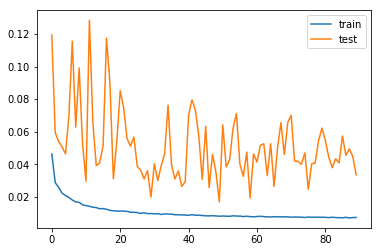

In [57]:
plot_training(history_lstm) 

In [58]:
trainScore = model_lstm.evaluate(train_X, train_y, verbose=0)
for i, m in enumerate(model_lstm.metrics_names):
    print('Train {0}: {1:5.4f}'.format(m, trainScore[i]))

testScore = model_lstm.evaluate(test_X, test_y, verbose=0)
for i, m in enumerate(model_lstm.metrics_names):
    print('Test {0}: {1:5.4f}'.format(m, testScore[i]))

Train loss: 0.0092
Train mean_squared_error: 0.0003
Train mean_absolute_error: 0.0092
Test loss: 0.0941
Test mean_squared_error: 0.0113
Test mean_absolute_error: 0.0941


### If pre-saved model is available, user may skip the above model loading and training and make prediction right from here onwards. Same steps applies for the next model, CNN hybrid model. 

#### Pre-trained model by local machine

In [35]:
model_lstm = load_model('./best_lstm_model_ip_{}.h5'.format(symbol))

#### Supplied pre-trained model:

In [17]:
model_lstm = load_model('./best_lstm_model_AAPL.h5')

In [18]:
# Get the predicted price
predicted_y_lstm = model_lstm.predict(test_X, batch_size=None, verbose=0, steps=None)
# Get the trained price
trained_y_lstm = model_lstm.predict(train_X, batch_size=None, verbose=0, steps=None)
# Vertically stack trained and predicted price into a dataframe to form a vector of price produced by CNN
y_lstm = pd.DataFrame(data=np.vstack((trained_y_lstm,predicted_y_lstm)), columns=['LSTM'], index = stock_context_fs.index )
# Assemble a dataframe with normalized price of original and CNN trained/predicted price
lstm_y_df = pd.concat([stock_context_fs[['Predict-Y']], y_lstm], axis=1)
# Assemble the dataframe resembles of the original stock dataframe for inverse transformation. 
lstm_df = stock_fs.loc[lstm_y_df.index]
# Replace the label column with the CNN trained & predicted price column
lstm_df[['Predict-Y']] = lstm_y_df[['LSTM']]
# Get it inverse transformed back to normal price
recovered_data_lstm = stock_data.minmaxed_scaler.inverse_transform(lstm_df)
recovered_data_lstm = pd.DataFrame(data=recovered_data_lstm, columns=stock_fs.columns, index=lstm_df.index)
recovered_data_lstm

,OpenT-0,VolumeT-0,VolumeT-1,VolumeT-2,MA5,ADX,MACD,RSI,AD,HT_DC,High/Open,Low/Open,Close/Open,Predict-Y
Date,,,,,,,,,,,,,,
2000-02-29,4.055804,92240400.0,0.685369,0.520005,89798240.0,8.893778,0.092730,54.142374,-5.916410e+08,21.434176,1.032471,0.991194,1.009356,3.762060
2000-03-01,4.234375,269250800.0,0.770189,0.685275,119993440.0,10.200601,0.134496,66.092019,-3.918742e+08,22.469111,1.113864,0.999473,1.099104,4.124621
2000-03-02,4.535714,77814800.0,2.248192,0.770084,116734800.0,11.414079,0.142004,57.536449,-4.415146e+08,23.169349,1.007382,0.950295,0.960630,4.239289
2000-03-03,4.459821,80841600.0,0.649738,2.247883,120445920.0,12.393048,0.163362,61.418684,-3.652731e+08,23.170201,1.026901,0.960961,1.025025,4.248227
2000-03-06,4.500000,52640000.0,0.675012,0.649649,114557520.0,13.420825,0.171645,59.173205,-4.003668e+08,22.666087,1.024802,0.992064,0.997520,4.302442
2000-03-07,4.515625,68252800.0,0.439534,0.674919,109760000.0,13.522058,0.168166,56.469185,-4.307764e+08,21.856956,1.007909,0.957983,0.971824,4.769906
2000-03-08,4.388393,67807600.0,0.569898,0.439473,69471360.0,13.100333,0.161031,55.617656,-4.118531e+08,21.113091,1.008647,0.964903,0.992879,4.006461
2000-03-09,4.316964,69179600.0,0.566180,0.569819,67744320.0,12.888930,0.154318,55.822620,-3.990424e+08,21.261594,1.034126,0.978283,1.011375,3.864451
2000-03-10,4.345982,62151600.0,0.577636,0.566102,64006320.0,13.175246,0.157272,58.698513,-3.760856e+08,22.072674,1.051361,0.994350,1.033385,4.290714


Plot saved as prediction_LSTM.png. When done viewing, please close this plot for next plot. Thank You!


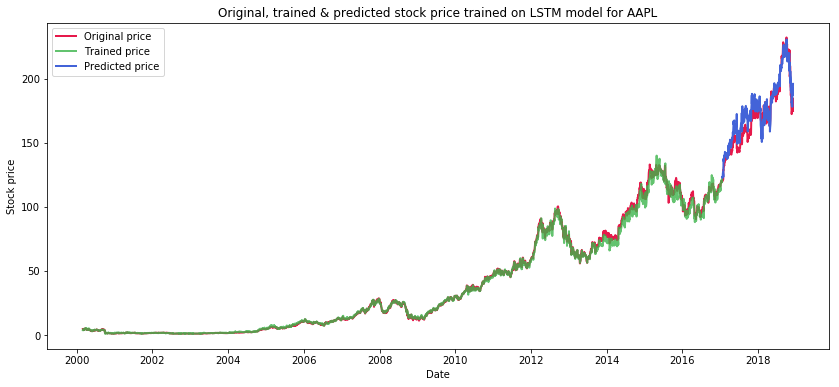

In [19]:
plot_prediction(
    stock_data.original[['Predict-Y']].loc[recovered_data_lstm.index], 
    recovered_data_lstm[['Predict-Y']] , len(trained_y_lstm), 
    "LSTM")

### Hybrid convolutional neural netowrk + Recurrent Neural network with LSTM training 

In [20]:
def split_data_cnn(df_values):
    # split into train and test sets
    n_train = TRAIN_PORTION * df_values.shape[0]
    train = df_values[:int(n_train), :]
    test = df_values[int(n_train):, :]
    # split into input and outputs
    train_X, train_y = train[:, :-1], train[:, -1]
    test_X, test_y = test[:, :-1], test[:, -1]
    # reshape input to be 3D [samples, timesteps, features]
    train_X = train_X.reshape((train_X.shape[0], train_X.shape[1], 1))
    test_X = test_X.reshape((test_X.shape[0], test_X.shape[1], 1))
    print(train_X.shape)
    print(train_y.shape)
    print(test_X.shape)
    print(test_y.shape)
    return train_X, train_y, test_X, test_y

train_X, train_y, test_X, test_y = split_data_cnn(df_values)

(4250, 25, 1)
(4250,)
(473, 25, 1)
(473,)


In [28]:
def build_cnn_model(train_X):
    print("\n")
    print("CNN + RNN LSTM model architecture ")
    model_cnn = Sequential()
    model_cnn.add(Conv1D(activation='linear',
                         kernel_initializer='uniform',
                         bias_initializer='zeros',
                         input_shape=(train_X.shape[1], train_X.shape[2]),
                         #kernel_regularizer=regularizers.l2(0.0001),
                         #activity_regularizer=regularizers.l1(0.0001),
                         filters=256, kernel_size=8))
    model_cnn.add(Conv1D(activation='linear',
                         kernel_initializer='uniform',
                         bias_initializer='zeros', filters=256, kernel_size=6))
    model_cnn.add(Dropout(0.25))
    model_cnn.add(MaxPooling1D(3))
    model_cnn.add(LSTM(128,
                       kernel_initializer='uniform',
                       bias_initializer='zeros'))
    model_cnn.add(Dropout(0.25))
    model_cnn.add(Dense(1))
    # optimizer = keras.optimizers.Adam(lr=0.00005, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
    # optimizer = keras.optimizers.Adam(lr=0.00001)
    optimizer = keras.optimizers.Adagrad(lr=0.01, epsilon=1e-08, decay=0.0002)
    #optimizer = keras.optimizers.RMSprop(lr=0.01, rho=0.9, epsilon=1e-08, decay=0.0002)
    model_cnn.compile(loss='mae', optimizer=optimizer, metrics=['mse', 'mae'])
    model_cnn.summary()
    return model_cnn
model_cnn = build_cnn_model(train_X)



CNN + RNN LSTM model architecture 
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 18, 256)           2304      
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 13, 256)           393472    
_________________________________________________________________
dropout_3 (Dropout)          (None, 13, 256)           0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 4, 256)            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 128)               197120    
_________________________________________________________________
dropout_4 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1) 

In [14]:
history_cnn, model_cnn = train_model(model_cnn, train_X, train_y, "CNN")

Loading pre-saved model ...
Train on 3022 samples, validate on 756 samples
Epoch 1/500
3022/3022 [==============================] - 12s 4ms/step - loss: 0.3536 - mean_squared_error: 7.6218e-04 - mean_absolute_error: 0.0182 - val_loss: 0.4658 - val_mean_squared_error: 0.0256 - val_mean_absolute_error: 0.1455

Epoch 00001: val_loss improved from inf to 0.46579, saving model to best_cnn_model.h5
Epoch 2/500
3022/3022 [==============================] - 10s 3ms/step - loss: 0.3274 - mean_squared_error: 6.8576e-04 - mean_absolute_error: 0.0173 - val_loss: 0.4455 - val_mean_squared_error: 0.0264 - val_mean_absolute_error: 0.1485

Epoch 00002: val_loss improved from 0.46579 to 0.44548, saving model to best_cnn_model.h5
Epoch 3/500
3022/3022 [==============================] - 10s 3ms/step - loss: 0.3037 - mean_squared_error: 5.9252e-04 - mean_absolute_error: 0.0162 - val_loss: 0.4497 - val_mean_squared_error: 0.0357 - val_mean_absolute_error: 0.1773

Epoch 00003: val_loss did not improve
Epoch 

3022/3022 [==============================] - 10s 3ms/step - loss: 0.0384 - mean_squared_error: 1.7635e-04 - mean_absolute_error: 0.0087 - val_loss: 0.1054 - val_mean_squared_error: 0.0079 - val_mean_absolute_error: 0.0748

Epoch 00055: val_loss improved from 0.11484 to 0.10541, saving model to best_cnn_model.h5
Epoch 56/500
3022/3022 [==============================] - 10s 3ms/step - loss: 0.0377 - mean_squared_error: 1.7042e-04 - mean_absolute_error: 0.0085 - val_loss: 0.1009 - val_mean_squared_error: 0.0073 - val_mean_absolute_error: 0.0712

Epoch 00056: val_loss improved from 0.10541 to 0.10094, saving model to best_cnn_model.h5
Epoch 57/500
3022/3022 [==============================] - 10s 3ms/step - loss: 0.0371 - mean_squared_error: 1.7165e-04 - mean_absolute_error: 0.0087 - val_loss: 0.1305 - val_mean_squared_error: 0.0126 - val_mean_absolute_error: 0.1018

Epoch 00057: val_loss did not improve
Epoch 58/500
3022/3022 [==============================] - 10s 3ms/step - loss: 0.0366 -

3022/3022 [==============================] - 10s 3ms/step - loss: 0.0204 - mean_squared_error: 1.0808e-04 - mean_absolute_error: 0.0069 - val_loss: 0.0851 - val_mean_squared_error: 0.0069 - val_mean_absolute_error: 0.0709

Epoch 00113: val_loss did not improve
Epoch 114/500
3022/3022 [==============================] - 10s 3ms/step - loss: 0.0204 - mean_squared_error: 1.1001e-04 - mean_absolute_error: 0.0070 - val_loss: 0.0973 - val_mean_squared_error: 0.0087 - val_mean_absolute_error: 0.0832

Epoch 00114: val_loss did not improve
Epoch 115/500
3022/3022 [==============================] - 10s 3ms/step - loss: 0.0202 - mean_squared_error: 1.0605e-04 - mean_absolute_error: 0.0069 - val_loss: 0.0955 - val_mean_squared_error: 0.0085 - val_mean_absolute_error: 0.0815

Epoch 00115: val_loss did not improve
Epoch 116/500
3022/3022 [==============================] - 10s 3ms/step - loss: 0.0201 - mean_squared_error: 1.0451e-04 - mean_absolute_error: 0.0069 - val_loss: 0.0971 - val_mean_squared_e

3022/3022 [==============================] - 10s 3ms/step - loss: 0.0156 - mean_squared_error: 7.1813e-05 - mean_absolute_error: 0.0057 - val_loss: 0.0777 - val_mean_squared_error: 0.0061 - val_mean_absolute_error: 0.0670

Epoch 00171: val_loss did not improve
Epoch 172/500
3022/3022 [==============================] - 10s 3ms/step - loss: 0.0156 - mean_squared_error: 7.3502e-05 - mean_absolute_error: 0.0057 - val_loss: 0.0746 - val_mean_squared_error: 0.0057 - val_mean_absolute_error: 0.0640

Epoch 00172: val_loss did not improve
Epoch 173/500
3022/3022 [==============================] - 10s 3ms/step - loss: 0.0155 - mean_squared_error: 7.3519e-05 - mean_absolute_error: 0.0057 - val_loss: 0.0673 - val_mean_squared_error: 0.0048 - val_mean_absolute_error: 0.0566

Epoch 00173: val_loss improved from 0.06800 to 0.06732, saving model to best_cnn_model.h5
Epoch 174/500
3022/3022 [==============================] - 10s 3ms/step - loss: 0.0154 - mean_squared_error: 7.0908e-05 - mean_absolute_e

#### A number of training curves after trying to adjust hyperparameters such as learning rate and decay rate a few optimizers.

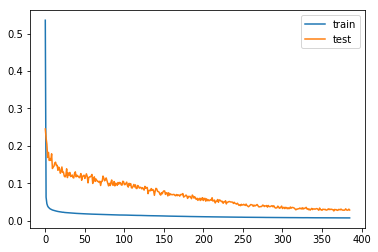

In [334]:
plot_training(history_cnn) 

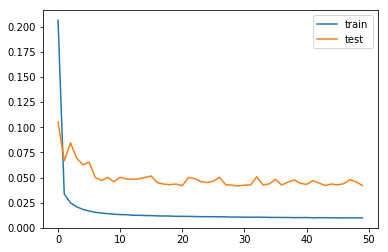

In [183]:
plot_training(history_cnn) 

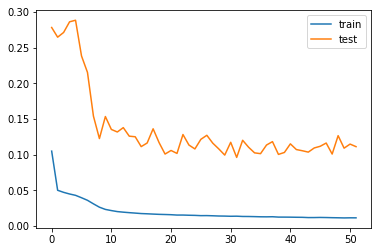

In [65]:
plot_training(history_cnn) 

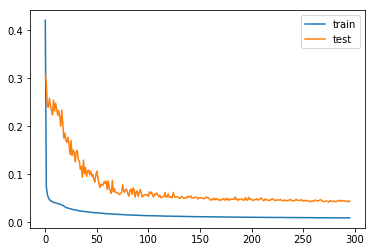

In [158]:
plot_training(history_cnn) 

In [333]:
trainScore = model_cnn.evaluate(train_X, train_y, verbose=0)
for i, m in enumerate(model_cnn.metrics_names):
    print('Train {0}: {1:5.4f}'.format(m, trainScore[i]))

testScore = model_cnn.evaluate(test_X, test_y, verbose=0)
for i, m in enumerate(model_cnn.metrics_names):
    print('Test {0}: {1:5.4f}'.format(m, testScore[i]))

Train loss: 0.0217
Train mean_squared_error: 0.0002
Train mean_absolute_error: 0.0067
Test loss: 0.2030
Test mean_squared_error: 0.0559
Test mean_absolute_error: 0.1855


#### If pre-saved model is available from previous training:

In [30]:
#model_cnn.save_weights('best_cnn_model.h5')
model_cnn = load_model('./best_cnn_model_ip_{}.h5'.format(symbol))

#### Supplied pre-trained model:

In [21]:
#model_cnn.save_weights('best_cnn_model.h5')
model_cnn = load_model('./best_cnn_model_AAPL.h5'.format(symbol))

In [32]:
# Get the predicted price
predicted_y_cnn = model_cnn.predict(test_X, batch_size=None, verbose=0, steps=None)
# Get the trained price
trained_y_cnn = model_cnn.predict(train_X, batch_size=None, verbose=0, steps=None)
# Vertically stack trained and predicted price into a dataframe to form a vector of price produced by CNN
y_cnn = pd.DataFrame(data=np.vstack((trained_y_cnn,predicted_y_cnn)), columns=['CNN'], index = stock_context_fs.index )
# Assemble a dataframe with normalized price of original and CNN trained/predicted price
cnn_y_df = pd.concat([stock_context_fs[['Predict-Y']], y_cnn], axis=1)
# Assemble the dataframe resembles of the original stock dataframe for inverse transformation. 
cnn_df = stock_fs.loc[cnn_y_df.index]
# Replace the label column with the CNN trained & predicted price column
cnn_df[['Predict-Y']] = cnn_y_df[['CNN']]
# Get it inverse transformed back to normal price
recovered_data_cnn = stock_data.minmaxed_scaler.inverse_transform(cnn_df)
recovered_data_cnn = pd.DataFrame(data=recovered_data_cnn, columns=stock_fs.columns, index=cnn_df.index)
recovered_data_cnn

,OpenT-0,VolumeT-0,VolumeT-1,VolumeT-2,MA5,ADX,MACD,RSI,AD,HT_DC,High/Open,Low/Open,Close/Open,Predict-Y
Date,,,,,,,,,,,,,,
2000-02-29,4.055804,92240400.0,0.685369,0.520005,89798240.0,8.893778,0.092730,54.142374,-5.916410e+08,21.434176,1.032471,0.991194,1.009356,-0.560120
2000-03-01,4.234375,269250800.0,0.770190,0.685275,119993440.0,10.200601,0.134496,66.092019,-3.918742e+08,22.469111,1.113864,0.999473,1.099104,-0.642102
2000-03-02,4.535714,77814800.0,2.248193,0.770084,116734800.0,11.414079,0.142004,57.536449,-4.415146e+08,23.169349,1.007382,0.950295,0.960630,-0.417760
2000-03-03,4.459821,80841600.0,0.649739,2.247884,120445920.0,12.393048,0.163362,61.418684,-3.652731e+08,23.170201,1.026901,0.960961,1.025025,-0.981145
2000-03-06,4.500000,52640000.0,0.675012,0.649649,114557520.0,13.420825,0.171645,59.173205,-4.003668e+08,22.666087,1.024802,0.992064,0.997520,0.222488
2000-03-07,4.515625,68252800.0,0.439534,0.674919,109760000.0,13.522058,0.168166,56.469185,-4.307764e+08,21.856956,1.007909,0.957983,0.971824,0.802547
2000-03-08,4.388393,67807600.0,0.569898,0.439474,69471360.0,13.100333,0.161031,55.617656,-4.118531e+08,21.113091,1.008647,0.964903,0.992879,-0.348262
2000-03-09,4.316964,69179600.0,0.566181,0.569820,67744320.0,12.888930,0.154318,55.822620,-3.990424e+08,21.261594,1.034126,0.978283,1.011375,-0.874525
2000-03-10,4.345982,62151600.0,0.577636,0.566103,64006320.0,13.175246,0.157272,58.698513,-3.760856e+08,22.072674,1.051361,0.994350,1.033385,-0.013128


Plot saved as prediction_CNN.png. When done viewing, please close this plot for next plot. Thank You!


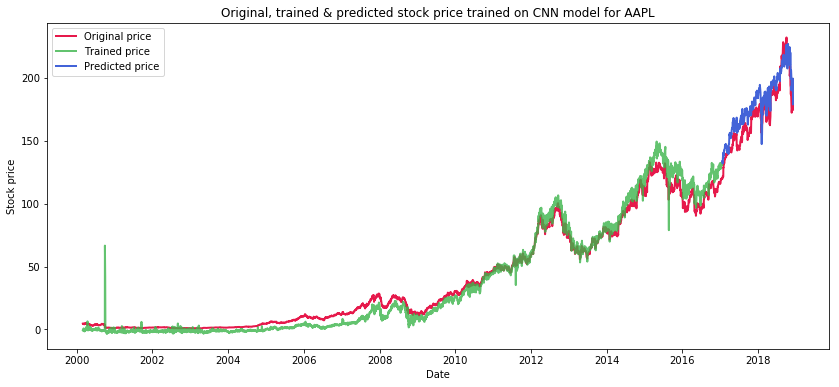

In [33]:
plot_prediction(
    stock_data.original[['Predict-Y']].loc[recovered_data_cnn.index], 
    recovered_data_cnn[['Predict-Y']] , len(trained_y_cnn), 
    "CNN")

## Conclusion

After trying a number of model architectures, optimizers, hyperparameter adjustment and normalization techniques, the results shows that it is possible to predict stock price. Perhaps, backtesting will be required to see if these models can make profitiable trading system. I reckon real world trading result will discount the backtesting result even further. So these models will need to have better generalization ability in order to get pass backtesting and eventually became a workable real wolrd trading algorithm. 

For improvements, I suggest: 

1. More context and fundamental data. 
2. Predict returns instead of price. 
3. Try reinforcement learning algorithm

## References

1. Display Deep Learning Model Training History in Keras, https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/
2.  Multivariate Time Series Forecasting with LSTMs in Keras, https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/
3. Deep Learning with Python, Francois Chollet, 2017
4. A Feature Selection Tool for Machine Learning in Python, https://towardsdatascience.com/a-feature-selection-tool-for-machine-learning-in-python-b64dd23710f0
5. Keras documentation, https://keras.io/
6. Dropout Regularization in Deep Learning Models With Keras, https://machinelearningmastery.com/dropout-regularization-deep-learning-models-keras/


In [1]:
class FeatureSelector():
    """
    Courtesy of William Koehrsen from Feature Labs
    Class for performing feature selection for machine learning or data preprocessing.

    Implements five different methods to identify features for removal

        1. Find columns with a missing percentage greater than a specified threshold
        2. Find columns with a single unique value
        3. Find collinear variables with a correlation greater than a specified correlation coefficient
        4. Find features with 0.0 feature importance from a gradient boosting machine (gbm)
        5. Find low importance features that do not contribute to a specified cumulative feature importance from the gbm

    Parameters
    --------
        data : dataframe
            A dataset with observations in the rows and features in the columns

        labels : array or series, default = None
            Array of labels for training the machine learning model to find feature importances. These can be either binary labels
            (if task is 'classification') or continuous targets (if task is 'regression').
            If no labels are provided, then the feature importance based methods are not available.

    Attributes
    --------

    ops : dict
        Dictionary of operations run and features identified for removal

    missing_stats : dataframe
        The fraction of missing values for all features

    record_missing : dataframe
        The fraction of missing values for features with missing fraction above threshold

    unique_stats : dataframe
        Number of unique values for all features

    record_single_unique : dataframe
        Records the features that have a single unique value

    corr_matrix : dataframe
        All correlations between all features in the data

    record_collinear : dataframe
        Records the pairs of collinear variables with a correlation coefficient above the threshold

    feature_importances : dataframe
        All feature importances from the gradient boosting machine

    record_zero_importance : dataframe
        Records the zero importance features in the data according to the gbm

    record_low_importance : dataframe
        Records the lowest importance features not needed to reach the threshold of cumulative importance according to the gbm


    Notes
    --------

        - All 5 operations can be run with the `identify_all` method.
        - If using feature importances, one-hot encoding is used for categorical variables which creates new columns

    """

    def __init__(self, data, labels=None):

        # Dataset and optional training labels
        self.data = data
        self.labels = labels

        if labels is None:
            print('No labels provided. Feature importance based methods are not available.')

        self.base_features = list(data.columns)
        self.one_hot_features = None

        # Dataframes recording information about features to remove
        self.record_missing = None
        self.record_single_unique = None
        self.record_collinear = None
        self.record_zero_importance = None
        self.record_low_importance = None

        self.missing_stats = None
        self.unique_stats = None
        self.corr_matrix = None
        self.feature_importances = None

        # Dictionary to hold removal operations
        self.ops = {}

        self.one_hot_correlated = False

    def identify_missing(self, missing_threshold):
        """Find the features with a fraction of missing values above `missing_threshold`"""

        self.missing_threshold = missing_threshold

        # Calculate the fraction of missing in each column
        missing_series = self.data.isnull().sum() / self.data.shape[0]
        self.missing_stats = pd.DataFrame(missing_series).rename(columns={'index': 'feature', 0: 'missing_fraction'})

        # Sort with highest number of missing values on top
        self.missing_stats = self.missing_stats.sort_values('missing_fraction', ascending=False)

        # Find the columns with a missing percentage above the threshold
        record_missing = pd.DataFrame(missing_series[missing_series > missing_threshold]).reset_index().rename(columns=
            {'index': 'feature', 0: 'missing_fraction'})

        to_drop = list(record_missing['feature'])

        self.record_missing = record_missing
        self.ops['missing'] = to_drop

        print('%d features with greater than %0.2f missing values.\n' % (
        len(self.ops['missing']), self.missing_threshold))

    def identify_single_unique(self):
        """Finds features with only a single unique value. NaNs do not count as a unique value. """

        # Calculate the unique counts in each column
        unique_counts = self.data.nunique()
        self.unique_stats = pd.DataFrame(unique_counts).rename(columns={'index': 'feature', 0: 'nunique'})
        self.unique_stats = self.unique_stats.sort_values('nunique', ascending=True)

        # Find the columns with only one unique count
        record_single_unique = pd.DataFrame(unique_counts[unique_counts == 1]).reset_index().rename(
            columns={'index': 'feature',
                     0: 'nunique'})

        to_drop = list(record_single_unique['feature'])

        self.record_single_unique = record_single_unique
        self.ops['single_unique'] = to_drop

        print('%d features with a single unique value.\n' % len(self.ops['single_unique']))

    def identify_collinear(self, correlation_threshold, one_hot=False):
        """
        Finds collinear features based on the correlation coefficient between features.
        For each pair of features with a correlation coefficient greather than `correlation_threshold`,
        only one of the pair is identified for removal.

        Using code adapted from: https://chrisalbon.com/machine_learning/feature_selection/drop_highly_correlated_features/

        Parameters
        --------

        correlation_threshold : float between 0 and 1
            Value of the Pearson correlation cofficient for identifying correlation features

        one_hot : boolean, default = False
            Whether to one-hot encode the features before calculating the correlation coefficients

        """

        self.correlation_threshold = correlation_threshold
        self.one_hot_correlated = one_hot

        # Calculate the correlations between every column
        if one_hot:

            # One hot encoding
            features = pd.get_dummies(self.data)
            self.one_hot_features = [column for column in features.columns if column not in self.base_features]

            # Add one hot encoded data to original data
            self.data_all = pd.concat([features[self.one_hot_features], self.data], axis=1)

            corr_matrix = pd.get_dummies(features).corr()

        else:
            corr_matrix = self.data.corr()

        self.corr_matrix = corr_matrix

        # Extract the upper triangle of the correlation matrix
        upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

        # Select the features with correlations above the threshold
        # Need to use the absolute value
        to_drop = [column for column in upper.columns if any(upper[column].abs() > correlation_threshold)]

        # Dataframe to hold correlated pairs
        record_collinear = pd.DataFrame(columns=['drop_feature', 'corr_feature', 'corr_value'])

        # Iterate through the columns to drop to record pairs of correlated features
        for column in to_drop:
            # Find the correlated features
            corr_features = list(upper.index[upper[column].abs() > correlation_threshold])

            # Find the correlated values
            corr_values = list(upper[column][upper[column].abs() > correlation_threshold])
            drop_features = [column for _ in range(len(corr_features))]

            # Record the information (need a temp df for now)
            temp_df = pd.DataFrame.from_dict({'drop_feature': drop_features,
                                              'corr_feature': corr_features,
                                              'corr_value': corr_values})

            # Add to dataframe
            record_collinear = record_collinear.append(temp_df, ignore_index=True)

        self.record_collinear = record_collinear
        self.ops['collinear'] = to_drop

        print('%d features with a correlation magnitude greater than %0.2f.\n' % (
        len(self.ops['collinear']), self.correlation_threshold))

    def identify_zero_importance(self, task, eval_metric=None,
                                 n_iterations=10, early_stopping=True):
        """

        Identify the features with zero importance according to a gradient boosting machine.
        The gbm can be trained with early stopping using a validation set to prevent overfitting.
        The feature importances are averaged over `n_iterations` to reduce variance.

        Uses the LightGBM implementation (http://lightgbm.readthedocs.io/en/latest/index.html)

        Parameters
        --------

        eval_metric : string
            Evaluation metric to use for the gradient boosting machine for early stopping. Must be
            provided if `early_stopping` is True

        task : string
            The machine learning task, either 'classification' or 'regression'

        n_iterations : int, default = 10
            Number of iterations to train the gradient boosting machine

        early_stopping : boolean, default = True
            Whether or not to use early stopping with a validation set when training


        Notes
        --------

        - Features are one-hot encoded to handle the categorical variables before training.
        - The gbm is not optimized for any particular task and might need some hyperparameter tuning
        - Feature importances, including zero importance features, can change across runs

        """

        if early_stopping and eval_metric is None:
            raise ValueError("""eval metric must be provided with early stopping. Examples include "auc" for classification or
                             "l2" for regression.""")

        if self.labels is None:
            raise ValueError("No training labels provided.")

        # One hot encoding
        features = pd.get_dummies(self.data)
        self.one_hot_features = [column for column in features.columns if column not in self.base_features]

        # Add one hot encoded data to original data
        self.data_all = pd.concat([features[self.one_hot_features], self.data], axis=1)

        # Extract feature names
        feature_names = list(features.columns)

        # Convert to np array
        features = np.array(features)
        labels = np.array(self.labels).reshape((-1,))

        # Empty array for feature importances
        feature_importance_values = np.zeros(len(feature_names))

        print('Training Gradient Boosting Model\n')

        # Iterate through each fold
        for _ in range(n_iterations):

            if task == 'classification':
                model = lgb.LGBMClassifier(n_estimators=1000, learning_rate=0.05, verbose=0)

            elif task == 'regression':
                model = lgb.LGBMRegressor(n_estimators=1000, learning_rate=0.05, verbose=0)

            else:
                raise ValueError('Task must be either "classification" or "regression"')

            # If training using early stopping need a validation set
            if early_stopping:

                train_features, valid_features, train_labels, valid_labels = train_test_split(features, labels,
                                                                                              test_size=0.15)
                # Train the model with early stopping
                model.fit(train_features, train_labels, eval_metric=eval_metric,
                          eval_set=[(valid_features, valid_labels)],
                          early_stopping_rounds=100, verbose=0)

                # Clean up memory
                gc.enable()
                del train_features, train_labels, valid_features, valid_labels
                gc.collect()

            else:
                model.fit(features, labels)

            # Record the feature importances
            feature_importance_values += model.feature_importances_ / n_iterations

        feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importance_values})

        # Sort features according to importance
        feature_importances = feature_importances.sort_values('importance', ascending=False).reset_index(drop=True)

        # Normalize the feature importances to add up to one
        feature_importances['normalized_importance'] = feature_importances['importance'] / feature_importances[
            'importance'].sum()
        feature_importances['cumulative_importance'] = np.cumsum(feature_importances['normalized_importance'])

        # Extract the features with zero importance
        record_zero_importance = feature_importances[feature_importances['importance'] == 0.0]

        to_drop = list(record_zero_importance['feature'])

        self.feature_importances = feature_importances
        self.record_zero_importance = record_zero_importance
        self.ops['zero_importance'] = to_drop

        print('\n%d features with zero importance after one-hot encoding.\n' % len(self.ops['zero_importance']))

    def identify_low_importance(self, cumulative_importance):
        """
        Finds the lowest importance features not needed to account for `cumulative_importance` fraction
        of the total feature importance from the gradient boosting machine. As an example, if cumulative
        importance is set to 0.95, this will retain only the most important features needed to
        reach 95% of the total feature importance. The identified features are those not needed.

        Parameters
        --------
        cumulative_importance : float between 0 and 1
            The fraction of cumulative importance to account for

        """

        self.cumulative_importance = cumulative_importance

        # The feature importances need to be calculated before running
        if self.feature_importances is None:
            raise NotImplementedError("""Feature importances have not yet been determined. 
                                         Call the `identify_zero_importance` method first.""")

        # Make sure most important features are on top
        self.feature_importances = self.feature_importances.sort_values('cumulative_importance')

        # Identify the features not needed to reach the cumulative_importance
        record_low_importance = self.feature_importances[
            self.feature_importances['cumulative_importance'] > cumulative_importance]

        to_drop = list(record_low_importance['feature'])

        self.record_low_importance = record_low_importance
        self.ops['low_importance'] = to_drop

        print('%d features required for cumulative importance of %0.2f after one hot encoding.' % (
        len(self.feature_importances) -
        len(self.record_low_importance), self.cumulative_importance))
        print('%d features do not contribute to cumulative importance of %0.2f.\n' % (len(self.ops['low_importance']),
                                                                                      self.cumulative_importance))

    def identify_all(self, selection_params):
        """
        Use all five of the methods to identify features to remove.

        Parameters
        --------

        selection_params : dict
           Parameters to use in the five feature selection methhods.
           Params must contain the keys ['missing_threshold', 'correlation_threshold', 'eval_metric', 'task', 'cumulative_importance']

        """

        # Check for all required parameters
        for param in ['missing_threshold', 'correlation_threshold', 'eval_metric', 'task', 'cumulative_importance']:
            if param not in selection_params.keys():
                raise ValueError('%s is a required parameter for this method.' % param)

        # Implement each of the five methods
        self.identify_missing(selection_params['missing_threshold'])
        self.identify_single_unique()
        self.identify_collinear(selection_params['correlation_threshold'])
        self.identify_zero_importance(task=selection_params['task'], eval_metric=selection_params['eval_metric'])
        self.identify_low_importance(selection_params['cumulative_importance'])

        # Find the number of features identified to drop
        self.all_identified = set(list(chain(*list(self.ops.values()))))
        self.n_identified = len(self.all_identified)

        print('%d total features out of %d identified for removal after one-hot encoding.\n' % (self.n_identified,
                                                                                                self.data_all.shape[1]))

    def check_removal(self, keep_one_hot=True):

        """Check the identified features before removal. Returns a list of the unique features identified."""

        self.all_identified = set(list(chain(*list(self.ops.values()))))
        print('Total of %d features identified for removal' % len(self.all_identified))

        if not keep_one_hot:
            if self.one_hot_features is None:
                print('Data has not been one-hot encoded')
            else:
                one_hot_to_remove = [x for x in self.one_hot_features if x not in self.all_identified]
                print('%d additional one-hot features can be removed' % len(one_hot_to_remove))

        return list(self.all_identified)

    def remove(self, methods, keep_one_hot=True):
        """
        Remove the features from the data according to the specified methods.

        Parameters
        --------
            methods : 'all' or list of methods
                If methods == 'all', any methods that have identified features will be used
                Otherwise, only the specified methods will be used.
                Can be one of ['missing', 'single_unique', 'collinear', 'zero_importance', 'low_importance']
            keep_one_hot : boolean, default = True
                Whether or not to keep one-hot encoded features

        Return
        --------
            data : dataframe
                Dataframe with identified features removed


        Notes
        --------
            - If feature importances are used, the one-hot encoded columns will be added to the data (and then may be removed)
            - Check the features that will be removed before transforming data!

        """

        features_to_drop = []

        if methods == 'all':

            # Need to use one-hot encoded data as well
            data = self.data_all

            print('{} methods have been run\n'.format(list(self.ops.keys())))

            # Find the unique features to drop
            features_to_drop = set(list(chain(*list(self.ops.values()))))

        else:
            # Need to use one-hot encoded data as well
            if 'zero_importance' in methods or 'low_importance' in methods or self.one_hot_correlated:
                data = self.data_all

            else:
                data = self.data

            # Iterate through the specified methods
            for method in methods:

                # Check to make sure the method has been run
                if method not in self.ops.keys():
                    raise NotImplementedError('%s method has not been run' % method)

                # Append the features identified for removal
                else:
                    features_to_drop.append(self.ops[method])

            # Find the unique features to drop
            features_to_drop = set(list(chain(*features_to_drop)))

        features_to_drop = list(features_to_drop)

        if not keep_one_hot:

            if self.one_hot_features is None:
                print('Data has not been one-hot encoded')
            else:

                features_to_drop = list(set(features_to_drop) | set(self.one_hot_features))

        # Remove the features and return the data
        data = data.drop(features_to_drop, axis=1)
        #data = data.drop(columns=features_to_drop)
        self.removed_features = features_to_drop

        if not keep_one_hot:
            print('Removed %d features including one-hot features.' % len(features_to_drop))
        else:
            print('Removed %d features.' % len(features_to_drop))

        return data

    def plot_missing(self):
        """Histogram of missing fraction in each feature"""
        if self.record_missing is None:
            raise NotImplementedError("Missing values have not been calculated. Run `identify_missing`")

        self.reset_plot()

        # Histogram of missing values
        plt.style.use('seaborn-white')
        plt.figure(figsize=(7, 5))
        plt.hist(self.missing_stats['missing_fraction'], bins=np.linspace(0, 1, 11), edgecolor='k', color='red',
                 linewidth=1.5)
        plt.xticks(np.linspace(0, 1, 11));
        plt.xlabel('Missing Fraction', size=14);
        plt.ylabel('Count of Features', size=14);
        plt.title("Fraction of Missing Values Histogram", size=16);

    def plot_unique(self):
        """Histogram of number of unique values in each feature"""
        if self.record_single_unique is None:
            raise NotImplementedError('Unique values have not been calculated. Run `identify_single_unique`')

        self.reset_plot()

        # Histogram of number of unique values
        self.unique_stats.plot.hist(edgecolor='k', figsize=(7, 5))
        plt.ylabel('Frequency', size=14);
        plt.xlabel('Unique Values', size=14);
        plt.title('Number of Unique Values Histogram', size=16);

    def plot_collinear(self, plot_all=False):
        """
        Heatmap of the correlation values. If plot_all = True plots all the correlations otherwise
        plots only those features that have a correlation above the threshold

        Notes
        --------
            - Not all of the plotted correlations are above the threshold because this plots
            all the variables that have been idenfitied as having even one correlation above the threshold
            - The features on the x-axis are those that will be removed. The features on the y-axis
            are the correlated features with those on the x-axis

        Code adapted from https://seaborn.pydata.org/examples/many_pairwise_correlations.html
        """

        if self.record_collinear is None:
            raise NotImplementedError('Collinear features have not been idenfitied. Run `identify_collinear`.')

        if plot_all:
            corr_matrix_plot = self.corr_matrix
            title = 'All Correlations'

        else:
            # Identify the correlations that were above the threshold
            # columns (x-axis) are features to drop and rows (y_axis) are correlated pairs
            corr_matrix_plot = self.corr_matrix.loc[list(set(self.record_collinear['corr_feature'])),
                                                    list(set(self.record_collinear['drop_feature']))]

            title = "Correlations Above Threshold"

        f, ax = plt.subplots(figsize=(10, 8))

        # Diverging colormap
        cmap = sns.diverging_palette(220, 10, as_cmap=True)

        # Draw the heatmap with a color bar
        sns.heatmap(corr_matrix_plot, cmap=cmap, center=0,
                    linewidths=.25, cbar_kws={"shrink": 0.6})

        # Set the ylabels
        ax.set_yticks([x + 0.5 for x in list(range(corr_matrix_plot.shape[0]))])
        ax.set_yticklabels(list(corr_matrix_plot.index), size=int(160 / corr_matrix_plot.shape[0]));

        # Set the xlabels
        ax.set_xticks([x + 0.5 for x in list(range(corr_matrix_plot.shape[1]))])
        ax.set_xticklabels(list(corr_matrix_plot.columns), size=int(160 / corr_matrix_plot.shape[1]));
        plt.title(title, size=14)

    def plot_feature_importances(self, plot_n=15, threshold=None):
        """
        Plots `plot_n` most important features and the cumulative importance of features.
        If `threshold` is provided, prints the number of features needed to reach `threshold` cumulative importance.

        Parameters
        --------

        plot_n : int, default = 15
            Number of most important features to plot. Defaults to 15 or the maximum number of features whichever is smaller

        threshold : float, between 0 and 1 default = None
            Threshold for printing information about cumulative importances

        """

        if self.record_zero_importance is None:
            raise NotImplementedError('Feature importances have not been determined. Run `idenfity_zero_importance`')

        # Need to adjust number of features if greater than the features in the data
        if plot_n > self.feature_importances.shape[0]:
            plot_n = self.feature_importances.shape[0] - 1

        self.reset_plot()

        # Make a horizontal bar chart of feature importances
        plt.figure(figsize=(10, 6))
        ax = plt.subplot()

        # Need to reverse the index to plot most important on top
        # There might be a more efficient method to accomplish this
        ax.barh(list(reversed(list(self.feature_importances.index[:plot_n]))),
                self.feature_importances['normalized_importance'][:plot_n],
                align='center', edgecolor='k')

        # Set the yticks and labels
        ax.set_yticks(list(reversed(list(self.feature_importances.index[:plot_n]))))
        ax.set_yticklabels(self.feature_importances['feature'][:plot_n], size=12)

        # Plot labeling
        plt.xlabel('Normalized Importance', size=16);
        plt.title('Feature Importances', size=18)
        plt.show()

        # Cumulative importance plot
        plt.figure(figsize=(6, 4))
        plt.plot(list(range(1, len(self.feature_importances) + 1)), self.feature_importances['cumulative_importance'],
                 'r-')
        plt.xlabel('Number of Features', size=14);
        plt.ylabel('Cumulative Importance', size=14);
        plt.title('Cumulative Feature Importance', size=16);

        if threshold:
            # Index of minimum number of features needed for cumulative importance threshold
            # np.where returns the index so need to add 1 to have correct number
            importance_index = np.min(np.where(self.feature_importances['cumulative_importance'] > threshold))
            plt.vlines(x=importance_index + 1, ymin=0, ymax=1, linestyles='--', colors='blue')
            plt.show();

            print('%d features required for %0.2f of cumulative importance' % (importance_index + 1, threshold))

    def reset_plot(self):
        plt.rcParams = plt.rcParamsDefault